In [2438]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import scatterplotmatrix as spx
import numpy as np
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.base import clone
from itertools import combinations
from collections import deque
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor, BaggingRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, SequentialFeatureSelector
import warnings
warnings.filterwarnings('ignore')

In [2439]:
np.random.seed(1)

<b>Data fields</b>
<ul>
    <li>Id - идентификационный номер квартиры</li>
    <li>DistrictId - идентификационный номер района</li>
    <li>Rooms - количество комнат</li>
    <li>Square - площадь</li>
    <li>LifeSquare - жилая площадь</li>
    <li>KitchenSquare - площадь кухни</li>
    <li>Floor - этаж</li>
    <li>HouseFloor - количество этажей в доме</li>
    <li>HouseYear - год постройки дома</li>
    <li>Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности</li>
    <li>Social_1, Social_2, Social_3 - социальные показатели местности</li>
    <li>Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья</li>
    <li>Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров</li>
    <li>Price - цена квартиры</li>
</ul>

In [2586]:
train_df = pd.read_csv('./flat_price/train.csv')
test_df = pd.read_csv('./flat_price/test.csv')

In [2441]:
train_df.shape[1] == test_df.shape[1] + 1

True

In [2442]:
train_df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962

In [2443]:
test_df.head(2)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567          44    1.0  36.847630   19.094182            5.0      5   
1  5925          62    1.0  42.493907   42.568133           10.0      7   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1970   0.036122         B         B        24      4378   
1        17.0       2017   0.072158         B         B         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         0        1036.0            1        1       B  
1         1           NaN            0        0       A

<b>Оптимизация памяти</b>

In [2444]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2445]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [2446]:
train_df.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

- square есть выбросы - большие величины, менее 5 м2
- rooms - выбросы комната = 0, 
- lifesquare - выбросы
- kitchensquare - выбросы

In [2447]:
train_df[train_df['HouseYear'] > 2021]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
8828  11607         147    2.0  44.791836   28.360393            5.0      4   
9163  10814         109    1.0  37.265070   20.239714            9.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
8828         9.0       4968   0.319809         B         B        25   
9163        12.0   20052011   0.136330         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
8828      4756        16        2857.0            5        8       B   
9163      6141        10         262.0            3        6       B   

              Price  
8828  243028.603096  
9163  254084.534396

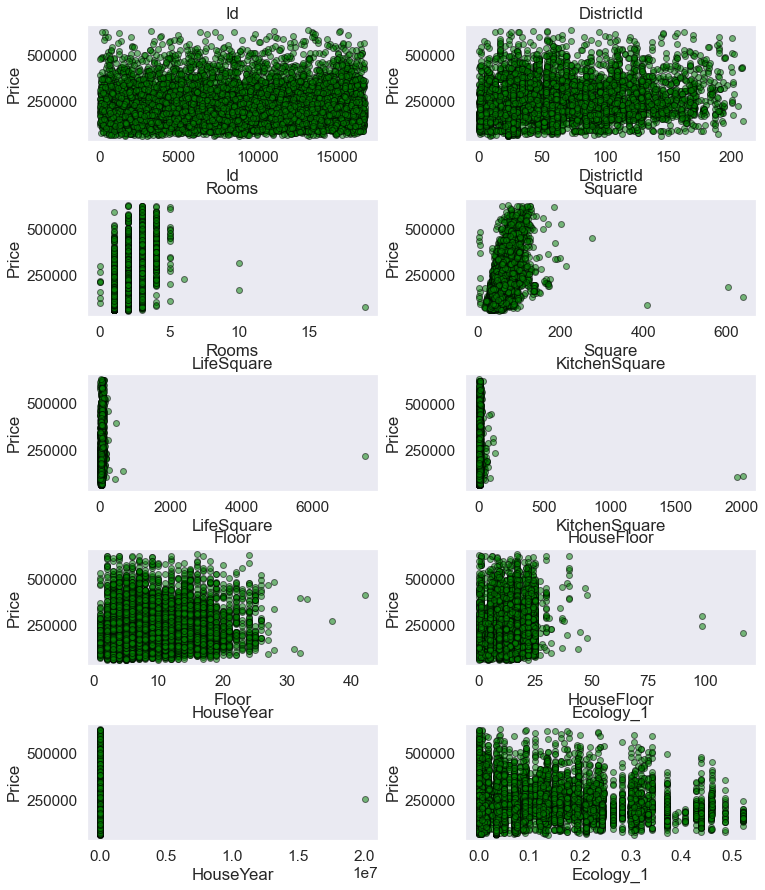

In [2448]:
# выведем простые изображения, чтобы грубо оценить наличие явных выбросов
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
ax = ax.flatten()
for idx, axe in enumerate(ax):
    axe.scatter(train_df.iloc[:, idx].values, train_df['Price'].values, color='green', ec='black', alpha=0.5)
    axe.set_title(f'{train_df.columns[idx]}')
    axe.set_xlabel(f'{train_df.columns[idx]}')
    axe.set_ylabel('Price')
    axe.grid(alpha=0.3)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

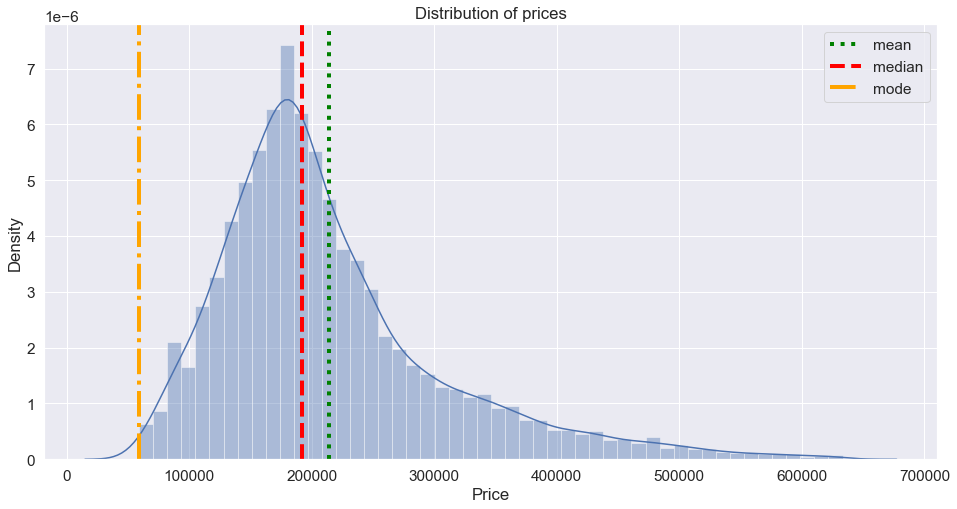

In [2449]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

plt.axvline(target_mean, label='mean', linestyle=':', color='green', linewidth=4)
plt.axvline(target_median, label='median', linestyle='--', color='red', linewidth=4)
plt.axvline(target_mode, label='mode', linestyle='-.', color='orange', linewidth=4)

plt.title('Distribution of prices')
plt.legend()
plt.show()
# линния моды в начале графика, видимо это из-за того, что значения цен уникальны

In [2450]:
len(np.unique(train_df['Price']))

10000

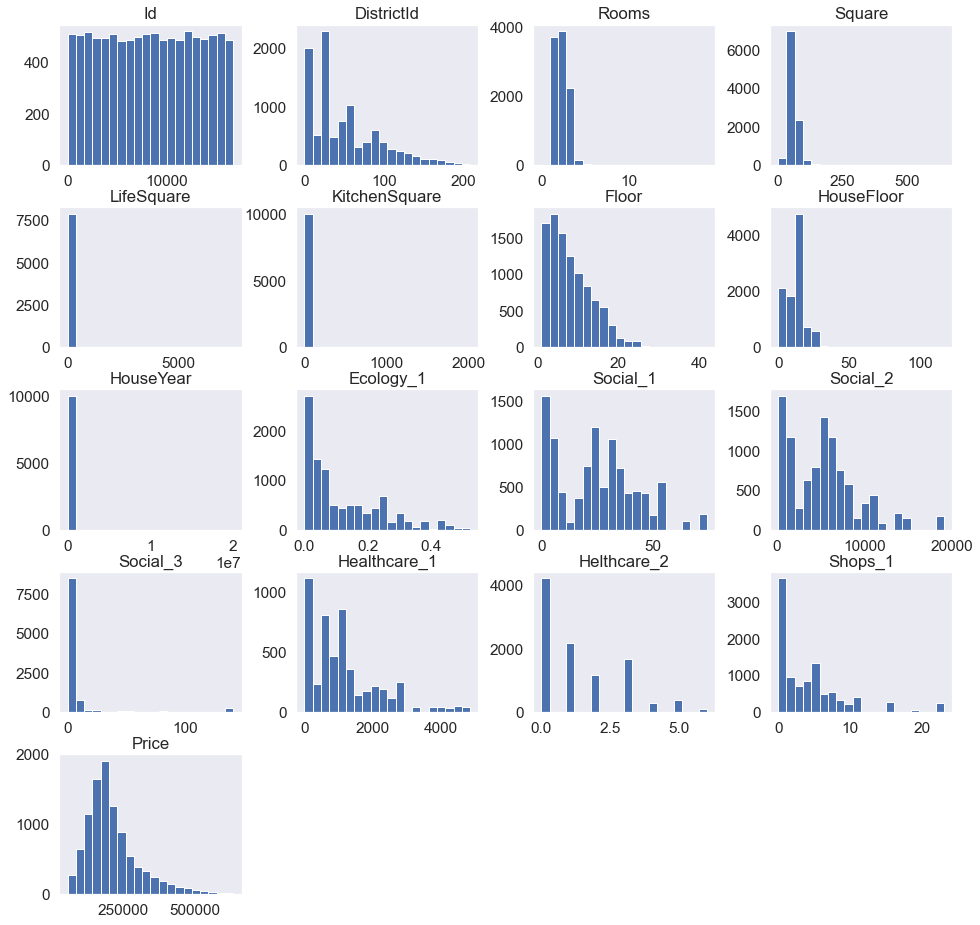

In [2451]:
train_df.hist(figsize=(16,16), bins=20, grid=False);

In [2452]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [2585]:
class Preprocessor:
    def __init__(self):
        self.medians = None
        self.districts_healthcare = None
        self.kitchen_max = None
        self.current_year = datetime.datetime.now().year
        self.temp_df = None
        self.max_square_outlier = None
        self.min_square_outlier = None
        self.median_dictrict_price = None
        self.district_price = None
        self.kitchen_square_outlier = None
        self.median_distrcit_price = None
        self.scaler = RobustScaler(with_centering=False)
        self.pca = PCA(n_components=1, random_state=1)
    
    def fit(self, df):
        self.medians = df.median()
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        self.kitchen_max = np.quantile(df['KitchenSquare'], q=0.975)
        self.max_square_outlier = np.quantile(df['Square'], q=0.975)
        self.min_square_outlier = np.quantile(df['Square'], q=0.0015)
        self.kitchen_square_outlier = np.quantile(df['KitchenSquare'], q=0.9975)
        self.temp_df = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})
        self.temp_df.columns = ['DistrictId', 'Rooms', 'MedPriceDistrict']
        self.median_dictrict_price = self.temp_df['MedPriceDistrict'].median()
        self.district_price = (df.groupby(['DistrictId'])['Price'].agg('median') \
                                                     / df.groupby(['DistrictId'])['Square'].agg('median')).to_dict()
    
    def transform(self, df):        
        # устранение выбросов
        df.loc[df['HouseYear'] > self.current_year, 'HouseYear'] = self.medians.HouseYear
        
        df.loc[df['Square'] > np.quantile(df['Square'], q=0.999), 'Square'] = self.max_square_outlier
        sq_condition = (df['Square'] < self.min_square_outlier)
        df.loc[sq_condition, 'Square'] = np.random.uniform(low=self.min_square_outlier,
                                                           high=self.min_square_outlier+5,
                                                           size=len(df[sq_condition]))
        square_condition = ((df['Square'] > 150) & (df['Rooms'] <= 3))
        df.loc[square_condition, 'Square'] = np.random.uniform(low=self.medians.Square, 
                                                               high=np.quantile(df['Square'], q=0.99),
                                                               size=len(df[square_condition]))
        
        kitchen_condition = (df['KitchenSquare'] > self.kitchen_square_outlier)
        df.loc[kitchen_condition, 'KitchenSquare'] = np.random.randint(low=self.medians.KitchenSquare,
                                                                       high=self.medians.KitchenSquare+6,
                                                                       size=len(df[kitchen_condition]))
        
        df.loc[df['LifeSquare'] > 200, 'LifeSquare'] = self.medians.LifeSquare
        
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'], (df['LifeSquare'], df['Square']),\
                                                  (df['Square'], df['LifeSquare']))
        
        df['Square'], df['KitchenSquare'] = np.where(df['Square'] < df['KitchenSquare'], \
                                                     (df['KitchenSquare'], df['Square']), \
                                                  (df['Square'], df['KitchenSquare']))
        
        floor_condition = (df['Floor'] > df['HouseFloor'])
        df.loc[floor_condition, 'HouseFloor'] = df.loc[floor_condition, 'Floor']
        
        rooms_condition = ((df['Rooms'] >= 6) | (df['Rooms'] == 0))
        room_median_square = np.round(self.medians.LifeSquare / self.medians.Rooms)
        df.loc[rooms_condition, 'Rooms'] = np.round(df.loc[rooms_condition, 'LifeSquare'] / room_median_square)
        
        # заполнение пропусков
        kitchen_condition = ((df['KitchenSquare'] > self.kitchen_max) | (df['KitchenSquare'].isna()))
        df.loc[kitchen_condition, 'KitchenSquare'] = self.medians.KitchenSquare
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.1), inplace=True)

        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)
        df['Healthcare_1'].clip(np.quantile(df['Healthcare_1'], q=0.97), axis=0, inplace=True)
        
        # преобразование категориальных признаков
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
                
        df.drop('Id', axis=1, inplace=True)

        # оптимизация памяти
        df = reduce_mem_usage(df)
        
        # если образовались пропуски
        df.fillna(self.medians, inplace=True)
        
        return df
    
    def create_features(self, df):
        
        # медианная цена за n-комнатную квартиру в отдельном районе    
        df = df.merge(self.temp_df, on=['DistrictId', 'Rooms'], how='left')
        df['MedPriceDistrict'].fillna(self.median_dictrict_price, inplace=True)
        
        # цена за квадратный метр в районе
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price)
        self.median_district_price = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price, inplace=True)
        
        # объединение социальных показателей в один признак и его масштабирование, т.к. по отдельности они не вносят особый вклад
        # применение PCA к бинарным данным может показаться некорректным, но результат лучше отдельных признаков,
        # несмотря на отсутствие, по сути, физического смысла в полученном признаке
        # можно было бы разбить Ecology_2, Ecology_3, Shops_2 с использованием dummies, но получится очень много признаков
        if 'Price' in df.columns:
            df['LifeStats'] = self.pca.fit_transform(self.scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3', 
                                                                                'Ecology_1', 'Ecology_2', 'Shops_1',
                                                                                'Shops_2']]))
        else:
            df['LifeStats'] = self.pca.transform(self.scaler.transform(df[['Social_1', 'Social_2', 'Social_3', 
                                                                                'Ecology_1', 'Ecology_2', 'Shops_1',
                                                                                'Shops_2']]))
        # дополнительно можно добавить признаки на основе разбиения на кластеры
            
        return df

In [2587]:
preprocessor = Preprocessor()
preprocessor.fit(train_df)

In [2613]:
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

KeyError: "['Id'] not found in axis"

In [2589]:
train_df = preprocessor.create_features(train_df)
test_df = preprocessor.create_features(test_df)

<b>Отбор признаков</b>

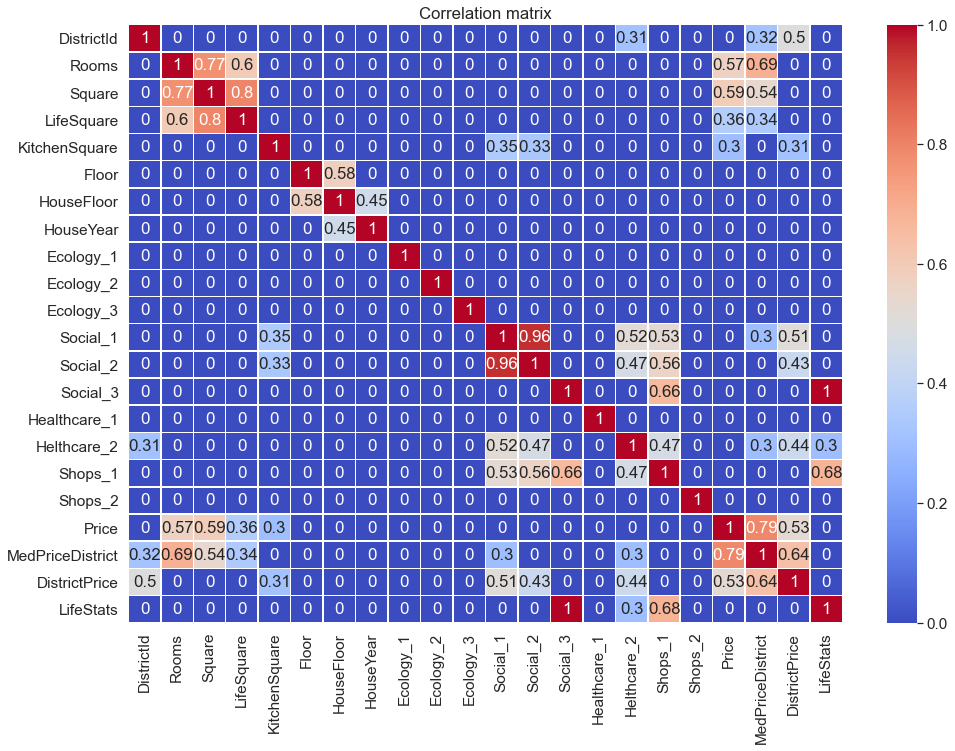

In [2265]:
plt.figure(figsize = (16,11))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()
# корреляция целевой переменной с Square после предобработки данных снизилась очень сильно, но нельзя делать прогнозы на заведомо ложных
# сведениях, в которых площадь жилой части или кухни больше площади всей квартиры

In [2266]:
# вспомогательные функции, написаны на коленке
from collections import deque

def select_features(df, threshold=0.7, min_features=5, target='Price', disc=True):
    cm = np.corrcoef(df.values.T)
    cm_indices = np.triu_indices(df.columns.values.shape[0], 1)
    dict_ = {(df.columns[idx], df.columns[jdx]): abs(cm[idx, jdx]) for idx, jdx in zip(*cm_indices)}
    result, counter = set(), threshold
    while counter > 0.1:
        if len(result) >= min_features:
            break
        for k, v in sorted(dict_.items(), key=lambda x: x[1], reverse=True):
            if k[1] == target and v >= counter:
                result.add(k[0]) if k[0] != target else result.add(k[1])
        counter -= 0.1
    if disc:
        for k in dict_.keys():
            if k[1] != target and ((k[0] in result) and (k[1] in result)) \
            and (dict_.get((k[0], k[1])) >= threshold):
                try:
                    result.discard(k[0]) if dict_.get((k[0], target)) < dict_.get((k[1], target)) \
                    else result.discard(k[1])
                except TypeError:
                    pass
    final_ = list(result)
    selected_df = df[[*final_, target]]
    return selected_df

def select_corr_feature(df, threshold=0.5, target='Price', disc=True):
    X_corr = df.corr()
    X_corr_sel = X_corr.drop(target, axis=0)[target]
    high_corr = [x for x, y in zip(X_corr_sel.index, X_corr_sel) if np.abs(y) > threshold]
    if disc:
        stack, high_, removed = deque(high_corr), set(), set()
        while len(stack) > 1:
            x = stack.popleft()
            for y in stack.copy():
                if np.abs(X_corr.loc[x, y]) >= threshold:
                    if np.abs(X_corr.loc[x, target]) > np.abs(X_corr.loc[y, target]):
                        high_.add(x)
                        if y in stack:
                            stack.remove(y)
                        high_.discard(y)
                        removed.add(y)
                    else:
                        high_.add(y)
                        if x in stack:
                            stack.remove(x)
                        high_.discard(x)
                        removed.add(x)
                else:
                    if x not in removed:
                        high_.add(x)
        high_corr = list(high_)
    return df[[*high_corr, target]]

def get_important_features(estimator, X, y):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    estimator.fit(X_std, y)
    tdf = train_df.drop('Price', axis=1)
    important_features = [feature for feature, weight in zip(list(tdf.columns), estimator.coef_.flatten())
                         if np.abs(weight) > 0.5]
    return important_features

In [2267]:
# функция для вывода оценки результатов работы обученной модели
def evaluate_preds(true_values, pred_values, save=False):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "MSE_scaled:\t" + str(round(mse(true_values, pred_values) / np.median(true_values), 3)))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 635000], [0, 635000], linestyle='--', color='red')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    if save:
        if not os.path.exists('./saved'):
            os.makedirs('./saved')
        plt.savefig('./saved' + 'report.png')
    plt.show()

In [2290]:
X, y = train_df.drop('Price', axis=1).values, train_df['Price'].values

In [2269]:
print(f'В X {X.shape[1]} признаков, {X.shape[0]} образцов. В целевой переменной {y.shape} значений')

В X 21 признаков, 10000 образцов. В целевой переменной (10000,) значений


In [2270]:
# получим важные признаки через веса 
test_lr = LinearRegression()

features = get_important_features(test_lr, X, y)
features

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'MedPriceDistrict',
 'DistrictPrice',
 'LifeStats']

In [2271]:
# disc = False, так как иначе останется совсем мало, True - удаляет признаки с наибольшей взаимной корреляцией 
# и меньшей по отношению к целевой переменной
select_corr_feature(train_df, threshold=0.3, disc=False).columns.to_list()

['Rooms', 'Square', 'LifeSquare', 'MedPriceDistrict', 'DistrictPrice', 'Price']

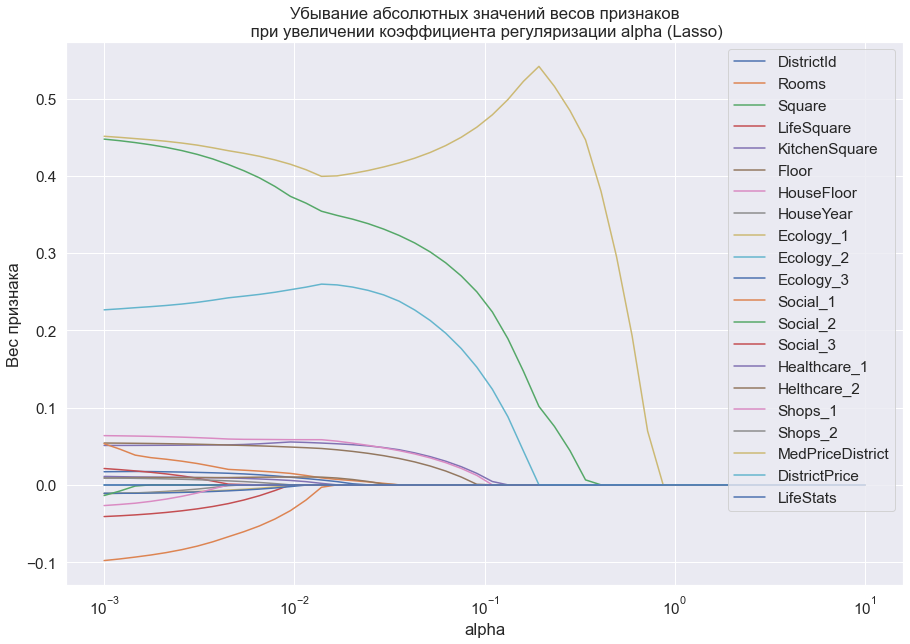

In [2292]:
n = 50
cols = train_df.drop('Price', axis=1).columns.to_list()
len_features = len(cols)
coeffs = np.zeros((n, len_features))
sc_x, sc_y = StandardScaler(), StandardScaler()
X_std, y_std = sc_x.fit_transform(X), sc_y.fit_transform(y[:, np.newaxis]).flatten()
X_scaled = pd.DataFrame(X_std, columns=cols)
alpha_list = np.logspace(-3, 1, n)

for i, val in enumerate(alpha_list):
    lasso = Lasso(alpha=val)
    lasso.fit(X_scaled, y_std)
    
    coeffs[i, :] = lasso.coef_.flatten()
plt.figure(figsize=(15, 10))
for i in range(len_features):
    plt.plot(alpha_list, coeffs[:, i])

plt.title('Убывание абсолютных значений весов признаков\n при увеличении коэффициента регуляризации alpha (Lasso)')

plt.xlabel('alpha')
plt.ylabel('Вес признака')
plt.legend(cols, loc='upper right')
plt.xscale('log')
plt.show()

1) MedPriceDistrict	0.6646104762932916
2) Square	0.15163668190922858
3) DistrictPrice	0.05885137351869379
4) HouseYear	0.022515633405794433
5) HouseFloor	0.016139666369083393
6) KitchenSquare	0.014376719794390317
7) LifeStats	0.013551109458126796
8) LifeSquare	0.011688763836157183
9) Floor	0.00813984767492828
10) Social_1	0.007431561928961691
11) Rooms	0.007170970874393567
12) Ecology_1	0.006311027152755989
13) DistrictId	0.005387671467737856
14) Social_2	0.004205605375389513
15) Social_3	0.0028777815120432956
16) Shops_1	0.0016305799617604888
17) Healthcare_1	0.0014998456538622995
18) Helthcare_2	0.0011538314671877463
19) Shops_2	0.00047345494160939825
20) Ecology_2	0.0002389557245648171
21) Ecology_3	0.00010844168003873505


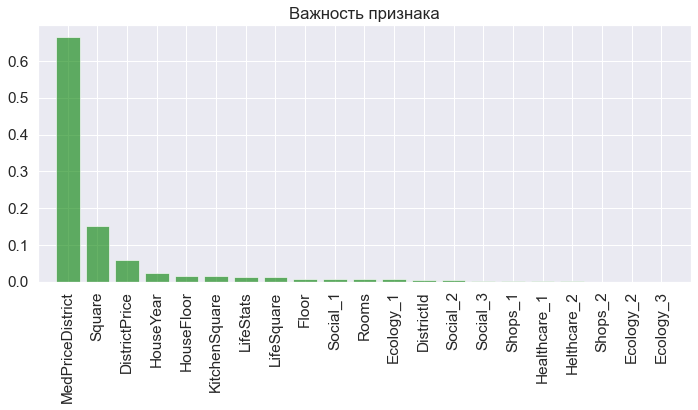

In [2273]:
# воспользуемся еще одним способом - через атрибут важности в случайном лесе либо как здесь в GradientBoostingRegressor
feat_labels = np.array(cols)
boost_test = GradientBoostingRegressor(n_estimators=500, random_state=1)
boost_test.fit(X, y)
importances = boost_test.feature_importances_
indices = np.argsort(importances)[::-1]
for x in range(X.shape[1]):
    print(f'{x+1}) {feat_labels[indices[x]]}\t{importances[indices[x]]}')
plt.figure(figsize=(10, 6))
plt.title('Важность признака')
plt.bar(range(X.shape[1]), importances[indices], align='center', alpha=0.6, color='green')
plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [2274]:
# класс, который выбирает наилучший поднабор признаков, исходя из заданной метрики
class ChooseBestSubset:
    def __init__(self, estimator, k_features, scoring='r2_score', test_size=0.25, random_state=1):
        self.scoring = str(scoring)
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        if (self.scoring == 'r2_score') or (self.scoring == 'mse'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'The scoring has to be "r2_score" or "mse", given: {self.scoring}')
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                           random_state=self.random_state)
        # закомментим, так как DecisionTree не нуждается в стандартизации признаков, экономия времени
        #sc_x, sc_y = StandardScaler(), StandardScaler()
        #X_train_std, y_train_std = sc_x.fit_transform(X_train), sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
        #X_test_std, y_test_std = sc_x.transform(X_test), sc_y.transform(y_test[:, np.newaxis]).flatten()
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores, subsets = [], []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores) if self.scoring == r2_score else np.argmin(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [2275]:
boost_test.n_estimators = 150 # чтобы не заснуть в процессе выборки
selector = ChooseBestSubset(boost_test, k_features=3)
selector.fit(X, y)

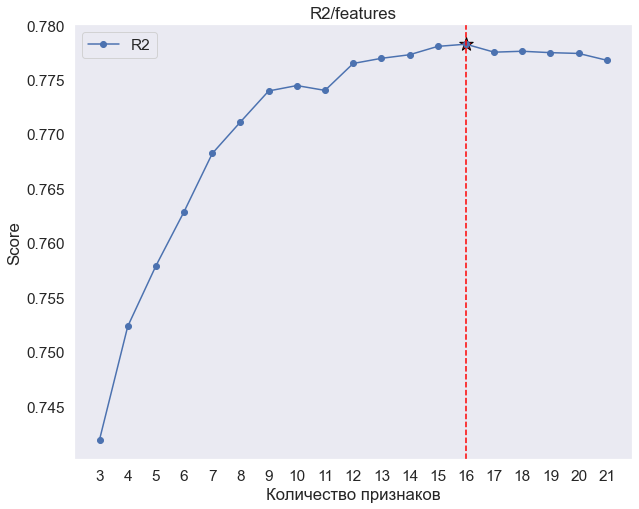

In [2276]:
k_feat = [len(k) for k in selector.subsets_]
plt.figure(figsize=(10, 8))
plt.plot(k_feat, selector.scores_, marker='o', label='R2')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', 
              ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('R2/features')
plt.ylabel('Score')
plt.xlabel('Количество признаков')
plt.legend(loc='best')
plt.xticks(k_feat)
plt.grid(color='orange', alpha=0.3)
plt.show()

In [2277]:
selector.subsets_[np.argmax(np.array(selector.scores_))]

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 18, 19, 20)

In [2278]:
columns = train_df.columns[train_df.columns != 'Price']
cols = [columns[i] for i in selector.subsets_[np.argmax(np.array(selector.scores_))]]
cols += ['Price']
df_selected_cbs = train_df[[*cols]]
df_selected_cbs.head(1)

DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0          27    3.0  115.027313   93.524582           10.0      4   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Social_1  Social_2  Social_3  \
0        10.0     2014.0   0.075424          1        11      3097         0   

   MedPriceDistrict  DistrictPrice  LifeStats       Price  
0     213530.788443    2669.535159  -1.710101  305018.875

In [2279]:
df_selected_cbs.shape

(10000, 17)

In [2280]:
# попробуем возможности sklearn
rfe_selector = RFE(estimator=GradientBoostingRegressor(n_estimators=100, random_state=1), 
                   n_features_to_select=14, step=1)
rfe_selector = rfe_selector.fit(X, y)

In [2281]:
ranked_features = rfe_selector.ranking_
raw_columns = np.where(ranked_features == 1, columns, None)
print(*list(raw_columns[raw_columns != None]), sep='\t-\t')

Rooms	-	Square	-	LifeSquare	-	KitchenSquare	-	Floor	-	HouseFloor	-	HouseYear	-	Ecology_1	-	Social_1	-	Social_2	-	Social_3	-	MedPriceDistrict	-	DistrictPrice	-	LifeStats


In [2282]:
# взяли поменьше признаков, чтобы сравнить самые ценные, ниже 5 признака идет уже мусор
sfs = SequentialFeatureSelector(GradientBoostingRegressor(n_estimators=100, random_state=1), 
                                n_features_to_select=15, 
                                scoring='r2', cv=3, n_jobs=-1)
sfs.fit(X, y)

SequentialFeatureSelector(cv=3,
                          estimator=GradientBoostingRegressor(random_state=1),
                          n_features_to_select=15, n_jobs=-1, scoring='r2')

In [2283]:
indices = sfs.get_support(indices=True)
print(*list(np.array(columns)[indices]), sep='\t-\t')

Rooms	-	Square	-	LifeSquare	-	HouseFloor	-	HouseYear	-	Ecology_1	-	Ecology_2	-	Ecology_3	-	Social_1	-	Social_2	-	Healthcare_1	-	Shops_2	-	MedPriceDistrict	-	DistrictPrice	-	LifeStats


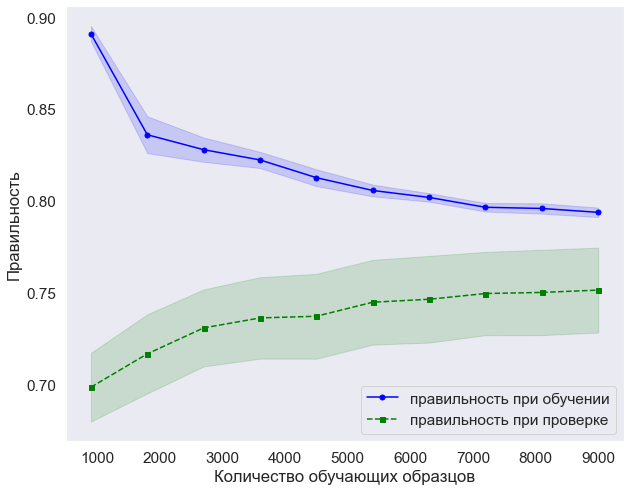

In [2284]:
# проанализируем оптимальное количество образцов
# код позволяет определить количество образцов для оптимального соотношения правильности при обучении и проверке
estimator = GradientBoostingRegressor(random_state=1, n_estimators=100)
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='lower right')
plt.show()
# выходит, что чем больше, тем лучше. Видимо, кстати, модель бустинга будет переобучаться и разрыв между обучающей
# и тестовой точностью будет непреодолим - надо пытаться его сократить

вывод: возьмем следующие признаки - DistrictId	Rooms Lifesquare	Square	KitchenSquare	Floor	HouseFloor	HouseYear	Ecology_1	Social_1	Social_2	Social_3	Healthcare_1	Helthcare_2	Shops_1	MedPriceDistrict	DistrictPrice

In [2362]:
X, y = train_df[['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Social_1', 
                 'Healthcare_1', 'MedPriceDistrict', 'DistrictPrice', 'LifeStats', 
                 'LifeSquare', 'Ecology_1']].values, train_df['Price'].values

<h3>Выбор модели</h3>

In [2294]:
# попробуем свою линейную регрессию 
class CustomLinearRegression:
    def __init__(self, eta=0.001, epochs=20, l2=0., seed=None):
        self.eta = eta
        self.epochs = epochs
        self.random = np.random.RandomState(seed)
        self.l2 = l2
    def fit(self, X, y):
        self.weights = self.random.normal(loc=0.0, scale=0.01,
                                      size=(1 + X.shape[1]))
        self.losses = []
        for _ in range(self.epochs):
            output = self.input_(X)
            errors = (output - y)
            grad = (X.T.dot(errors) + self.l2 * self.weights[1:])
            self.weights[1:] -= self.eta * grad
            self.weights[0] -= self.eta * errors.sum()
            l2_term = self.l2 * np.sum(self.weights[1:]**2)
            loss = (errors**2).sum() / 2.0 + l2_term
            self.losses.append(loss)
        return self
    def input_(self, X):
        return np.dot(X, self.weights[1:]) + self.weights[0]
    def predict(self, X):
        return self.input_(X)

In [2295]:
# словарь для аггрегации результатов работы моделей
r2_dict = {}

In [2296]:
def cross_score(X, y, clf, num_splits=5, scoring=None):
    scores = cross_val_score(estimator=clf, X=X, y=y, scoring=scoring, cv=num_splits, n_jobs=-1)
    print(f'Accuracy on cross_validation: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

R2:	0.71
RMSE:	50156.678
MSE:	2515692369.392
MSE_scaled:	13081.847


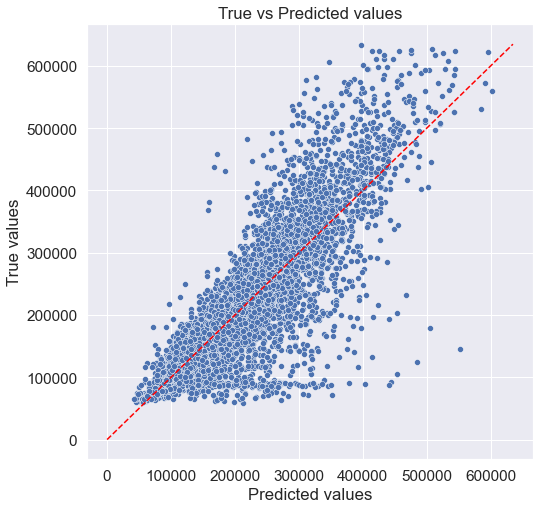

R2:	0.733
RMSE:	46300.317
MSE:	2143719376.906
MSE_scaled:	11166.317


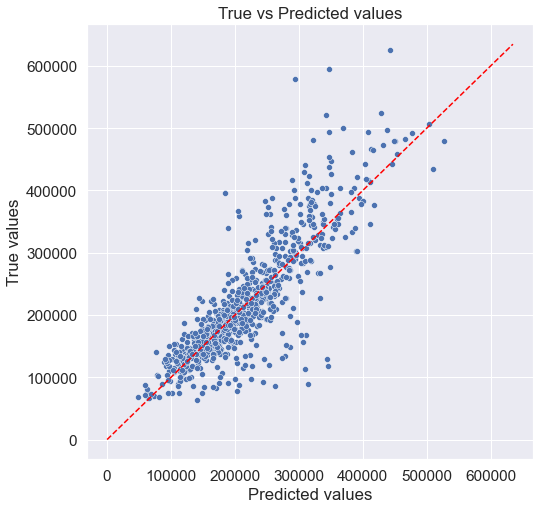

In [2297]:
split_ = int(0.91 * X.shape[0])
indices = np.arange(X.shape[0])
#np.random.shuffle(indices)
train_ind, test_ind = indices[:split_], indices[split_:]
X_train, X_test = X[train_ind, :], X[test_ind, :]
y_train, y_test = y[train_ind], y[test_ind]
X_train_std, y_train_std = sc_x.fit_transform(X_train), sc_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
X_test_std, y_test_std = sc_x.transform(X_test), sc_y.transform(y_test.reshape(-1, 1)).reshape(-1)
lr = CustomLinearRegression(seed=1, epochs=100, eta=0.00001, l2=0.1) 
lr.fit(X_train_std, y_train)
y_train_pred = lr.predict(X_train_std)
y_test_pred = lr.predict(X_test_std)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({lr.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

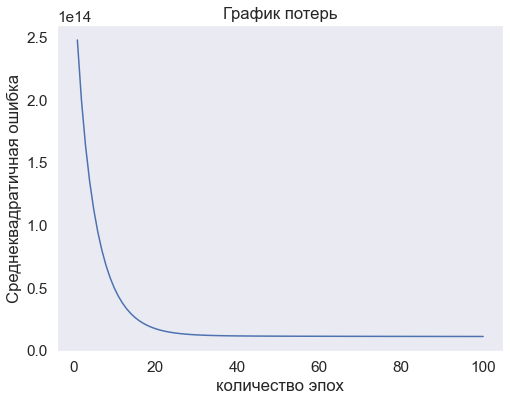

In [2298]:
plt.figure(figsize=(8,6))
plt.plot(range(1, lr.epochs + 1), lr.losses)
plt.ylabel('Среднеквадратичная ошибка')
plt.xlabel('количество эпох')
plt.title('График потерь')
plt.grid(alpha=0.3, color='orange')
plt.show()

In [2363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [2300]:
sc_x, sc_y = StandardScaler(), StandardScaler()
X_train_std, y_train_std = sc_x.fit_transform(X_train), sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
X_test_std, y_test_std = sc_x.transform(X_test), sc_y.transform(y_test[:, np.newaxis]).flatten()

<b>Линейная регрессия</b>

R2:	0.713
RMSE:	49299.257
MSE:	2430416703.439
MSE_scaled:	12655.872


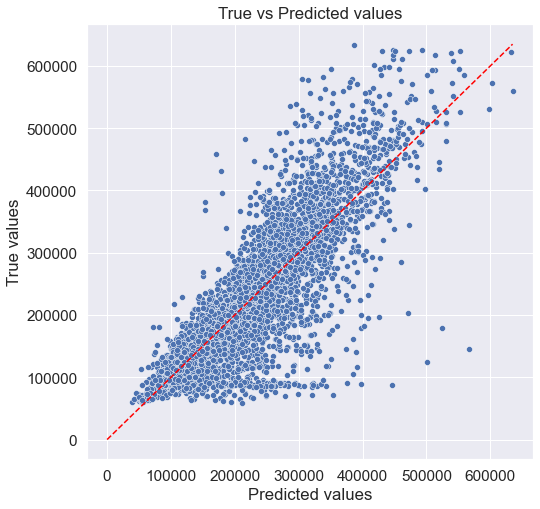

R2:	0.722
RMSE:	50769.889
MSE:	2577581607.039
MSE_scaled:	13373.17


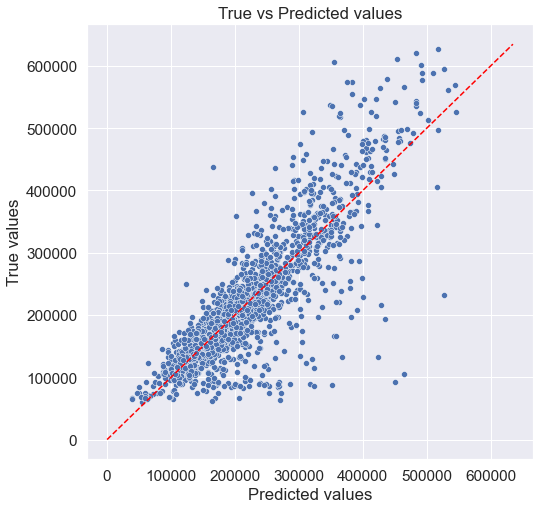

In [2301]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_std, y_train)
y_train_pred = lin_reg.predict(X_train_std)
y_test_pred = lin_reg.predict(X_test_std)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({lin_reg.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

In [2302]:
cross_score(X_train_std, y_train, lin_reg)

Accuracy on cross_validation: 0.710 +/- 0.029


array([0.7394911 , 0.68959114, 0.74709066, 0.70375568, 0.67240953])

<b>Lasso, Ridge</b>

In [1824]:
param_grid = [{
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10., 100.],
    'tol': [1e-3, 1e-4],
    'normalize': [True, False],
}]

In [1825]:
gs = GridSearchCV(estimator=Lasso(random_state=1), param_grid=param_grid, scoring=r2_score, 
                  cv=5, refit=True, n_jobs=-1)
gs = gs.fit(X_train_std, y_train)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
print('правильность при испытании: %.3f' % clf.score(X_test_std, y_test))

{'alpha': 0.0001, 'normalize': True, 'tol': 0.001}
правильность при испытании: 0.694


R2:	0.713
RMSE:	49299.257
MSE:	2430416703.442
MSE_scaled:	12655.872


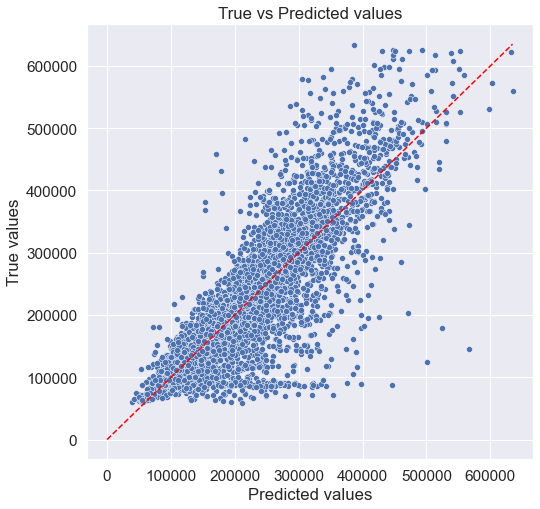

R2:	0.722
RMSE:	50769.888
MSE:	2577581546.927
MSE_scaled:	13373.17


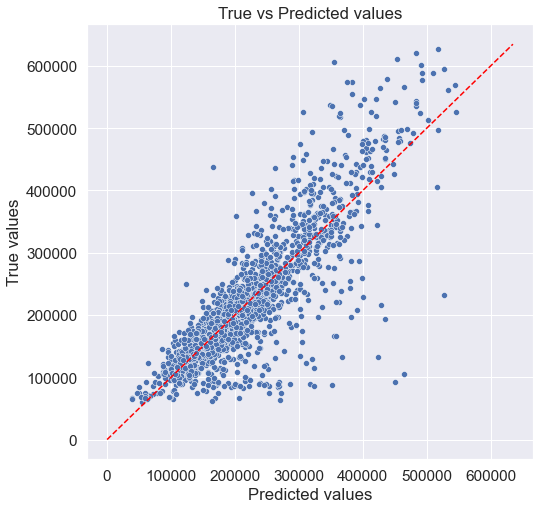

In [2303]:
lasso = Lasso(alpha=0.0001, normalize=True, tol=1e-3, random_state=1)
lasso.fit(X_train_std, y_train)
y_train_pred = lasso.predict(X_train_std)
y_test_pred = lasso.predict(X_test_std)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({lasso.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

R2:	0.713
RMSE:	49299.418
MSE:	2430432594.153
MSE_scaled:	12655.955


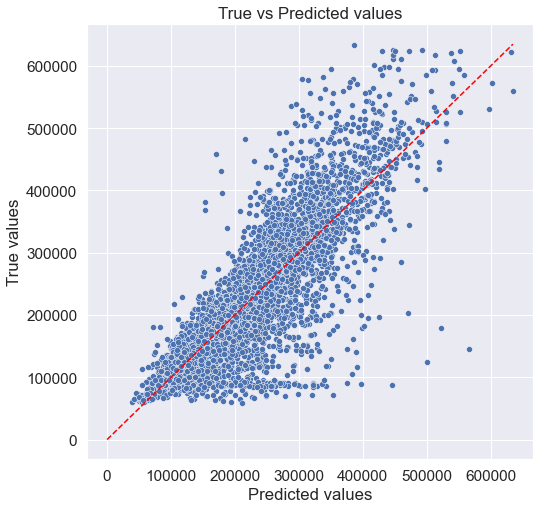

R2:	0.722
RMSE:	50770.155
MSE:	2577608679.501
MSE_scaled:	13373.311


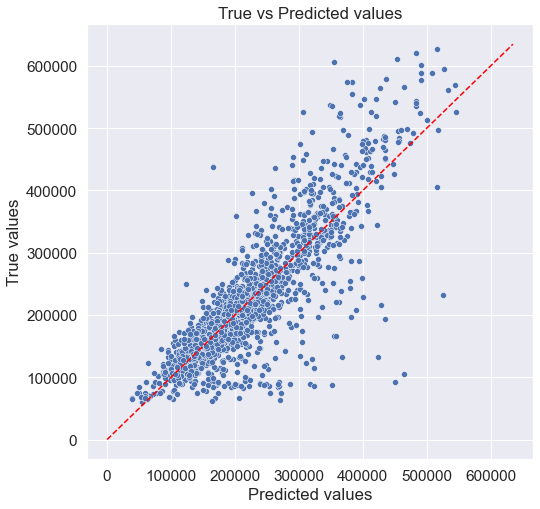

In [2304]:
ridge = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.], normalize=True, cv=5)
ridge.fit(X_train_std, y_train)
y_train_pred = ridge.predict(X_train_std)
y_test_pred = ridge.predict(X_test_std)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({ridge.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

<b>DecisionTreeRegressor</b>

In [1828]:
param_grid = [{
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_leaf': [1, 5, 10, 15],
    'max_features': [None, 5, 10],
}]

In [1829]:
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=1), param_grid=param_grid, scoring=r2_score, 
                  cv=5, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('правильность при испытании: %.3f' % clf.score(X_test, y_test))

{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1}
правильность при испытании: 0.656


R2:	0.719
RMSE:	48790.282
MSE:	2380491587.675
MSE_scaled:	12395.898


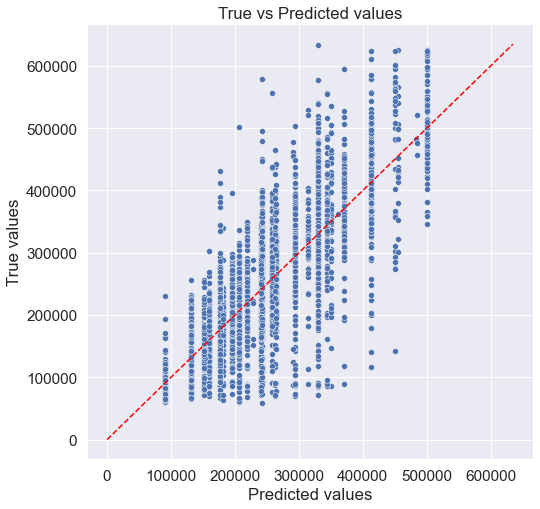

R2:	0.724
RMSE:	50665.332
MSE:	2566975824.617
MSE_scaled:	13318.145


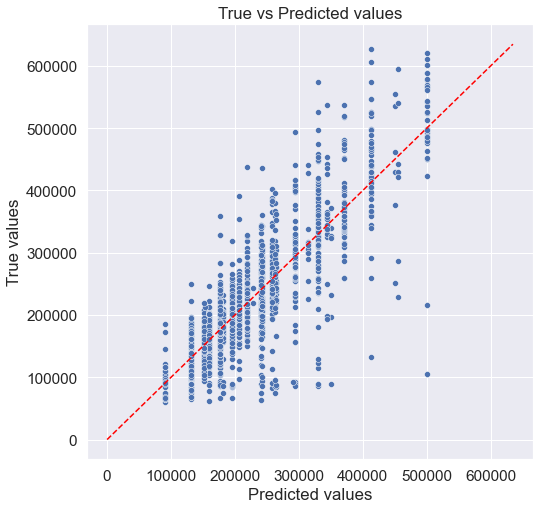

In [2305]:
tree = DecisionTreeRegressor(max_depth=5, max_features=None, min_samples_leaf=1, random_state=1)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({tree.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})
# очень странный график - как будто модель раскидала цены по категориям цен, и это не хорошо

<b>KNeighborsRegressor</b>

In [1832]:
param_grid = [{
    'n_neighbors': [5, 10, 20, 25, 30],
    'p': [1, 2, 3],
    'leaf_size': [15, 30, 45],
}]

In [1833]:
gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, 
                  scoring=r2_score, 
                  cv=5, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('правильность при испытании: %.3f' % clf.score(X_test, y_test))

{'leaf_size': 15, 'n_neighbors': 5, 'p': 1}
правильность при испытании: 0.703


R2:	0.724
RMSE:	48302.367
MSE:	2333118700.0
MSE_scaled:	12149.214


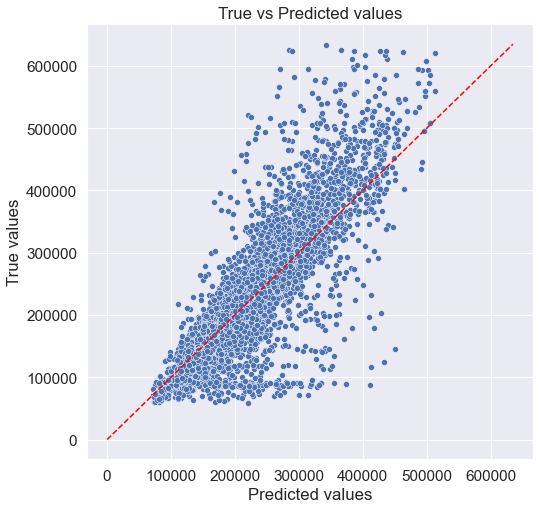

R2:	0.723
RMSE:	50727.8
MSE:	2573310000.0
MSE_scaled:	13351.008


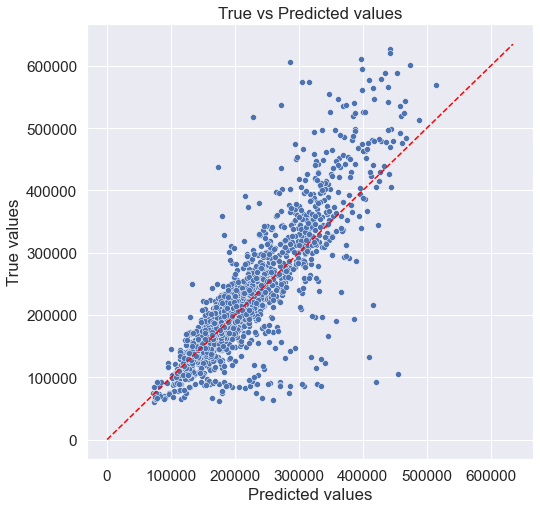

In [2306]:
knnr = make_pipeline(RobustScaler(), KNeighborsRegressor(n_neighbors=25, leaf_size=15, p=1, metric='minkowski'))
knnr.fit(X_train, y_train)
y_train_pred = knnr.predict(X_train)
y_test_pred = knnr.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({knnr.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

In [2307]:
cross_score(X=X_train, y=y_train, clf=knnr)

Accuracy on cross_validation: 0.686 +/- 0.015


array([0.69243662, 0.66414826, 0.70447555, 0.69427138, 0.67299208])

<b>RandomForestRegressor</b>

R2:	0.747
RMSE:	46222.872
MSE:	2136553852.965
MSE_scaled:	11125.645


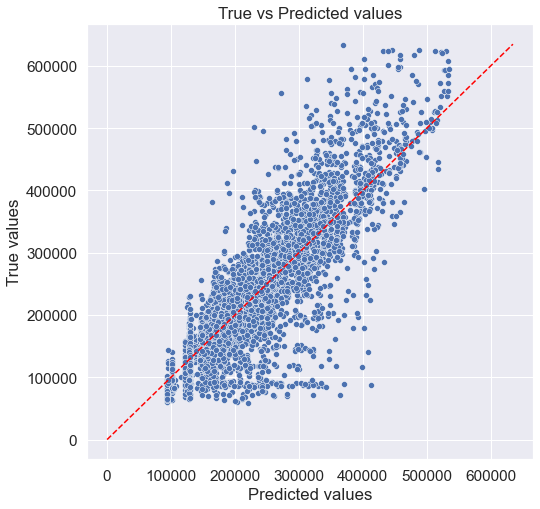

R2:	0.737
RMSE:	49382.48
MSE:	2438629304.64
MSE_scaled:	12652.249


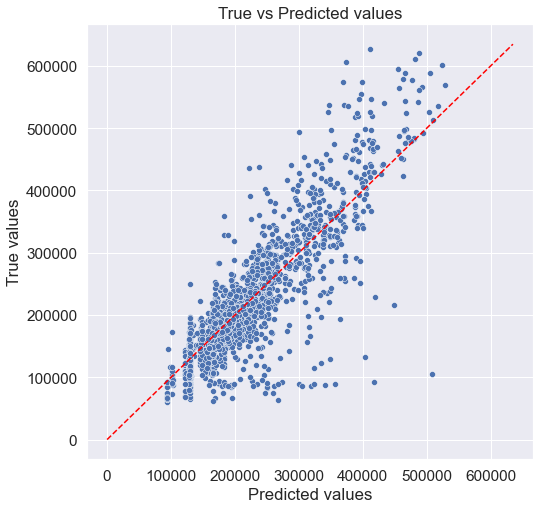

In [2308]:
forest = RandomForestRegressor(max_depth=5, max_features=13, n_estimators=1000, random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({forest.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

In [2309]:
cross_score(X_train, y_train, forest)

Accuracy on cross_validation: 0.715 +/- 0.029


array([0.73472952, 0.70086181, 0.76131156, 0.69632617, 0.68090569])

<b>GradientBoostingRegressor</b>

In [1843]:
param_grid = [{
    'n_estimators': [100, 500, 1000],
    'max_depth': [4, 5, 6],
}]

In [1844]:
gs = GridSearchCV(estimator=GradientBoostingRegressor(random_state=1), param_grid=param_grid, 
                  scoring=r2_score, 
                  cv=5, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('правильность при испытании: %.3f' % clf.score(X_test, y_test))

{'max_depth': 4, 'n_estimators': 100}
правильность при испытании: 0.775


R2:	0.785
RMSE:	42642.706
MSE:	1818400374.909
MSE_scaled:	9468.929


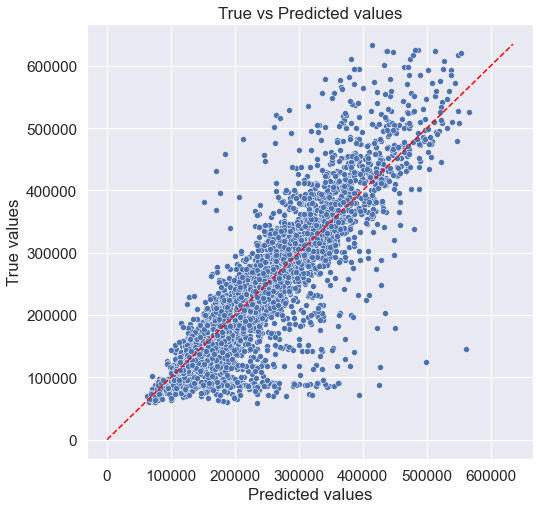

R2:	0.773
RMSE:	45933.297
MSE:	2109867774.668
MSE_scaled:	10946.548


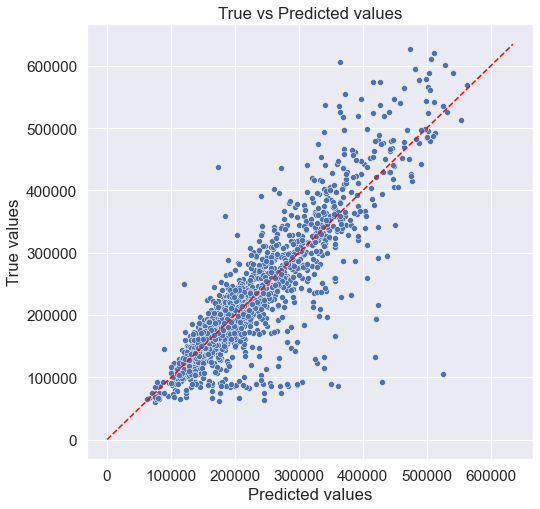

In [2367]:
boost = GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, 
                                  random_state=1, n_estimators=575, 
                                  max_features='sqrt', loss='huber', learning_rate=0.017)
boost.fit(X_train, y_train)
y_train_pred = boost.predict(X_train)
y_test_pred = boost.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({boost.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

In [1874]:
cross_score(X_train, y_train, boost)

Accuracy on cross_validation: 0.751 +/- 0.024


array([0.76605608, 0.72847374, 0.79004165, 0.74415679, 0.72534602])

<b>BaggingRegressor</b>

R2:	0.775
RMSE:	43670.229
MSE:	1907088879.991
MSE_scaled:	9930.755


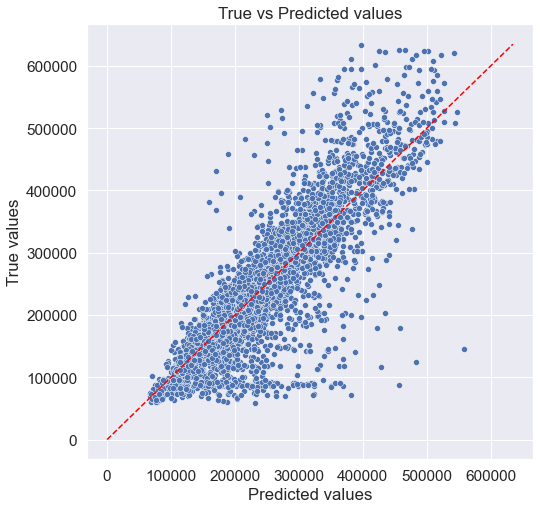

R2:	0.769
RMSE:	46329.297
MSE:	2146403779.862
MSE_scaled:	11136.106


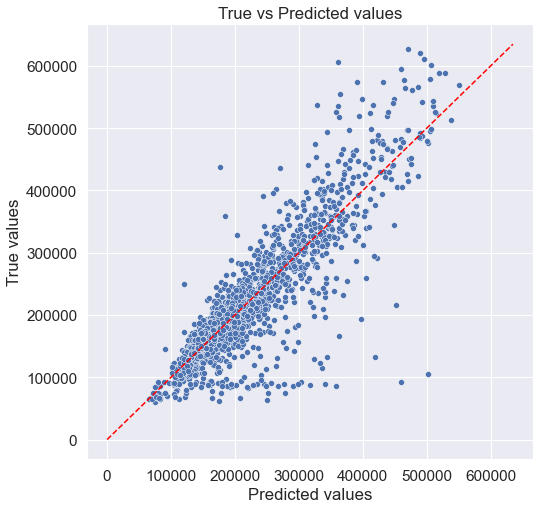

In [2317]:
# на стандартном дереве принятия решений выжимает максимум 0.74 на тестовой и 0.749 на тренировочной
bag = BaggingRegressor(base_estimator=GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, 
                                  random_state=1, n_estimators=575, 
                                  max_features='sqrt', loss='huber', learning_rate=0.017),
                      max_features=13, n_estimators=15,
                      random_state=1, n_jobs=-1)
bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({bag.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

<b>StackingRegressor</b>

R2:	0.801
RMSE:	41023.997
MSE:	1682968353.274
MSE_scaled:	8763.696


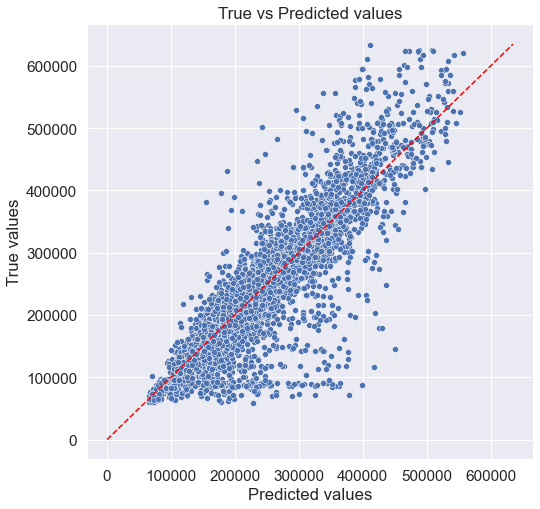

R2:	0.774
RMSE:	45850.311
MSE:	2102251060.355
MSE_scaled:	10907.031


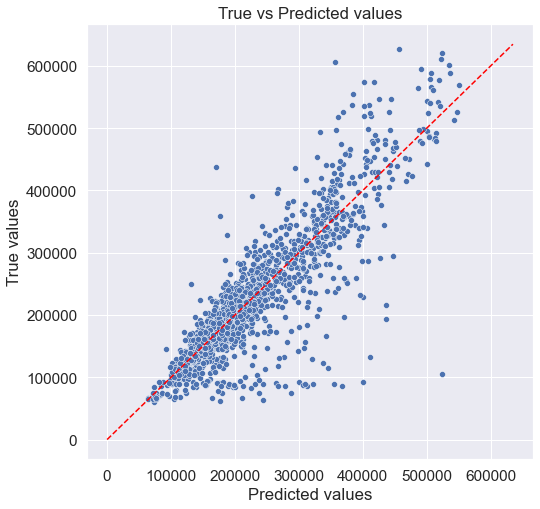

In [2318]:
estimators = [
  ('knn', make_pipeline(RobustScaler(), KNeighborsRegressor(n_neighbors=25, leaf_size=15, p=1, 
                                                            metric='minkowski'))), 
  ('fosest', RandomForestRegressor(max_depth=5, max_features=13, n_estimators=1000, random_state=1, n_jobs=-1)),
  ('bag', BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5, max_features=None, 
                                                                min_samples_leaf=1, random_state=1),
                      max_features=13, n_estimators=200, random_state=1, n_jobs=-1))
]
final_estimator = GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, 
                                  random_state=1, n_estimators=575, 
                                  max_features='sqrt', loss='huber', learning_rate=0.017)
stack = StackingRegressor(estimators=estimators, final_estimator=final_estimator, passthrough=True, n_jobs=-1)
stack.fit(X_train, y_train)
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({stack.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

<b>VotingRegressor</b>

R2:	0.772
RMSE:	43939.875
MSE:	1930712607.101
MSE_scaled:	10053.771


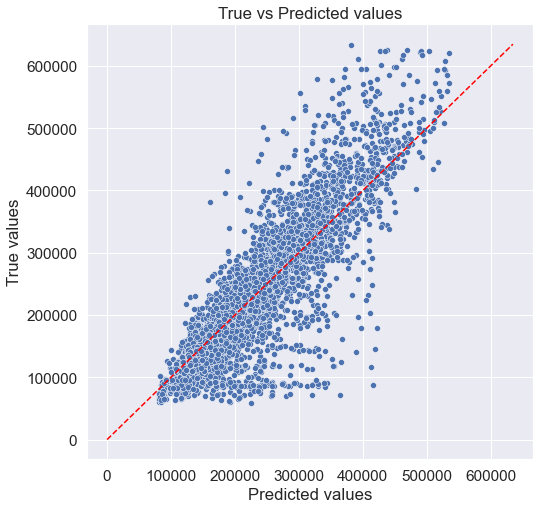

R2:	0.761
RMSE:	47142.838
MSE:	2222447166.2
MSE_scaled:	11530.639


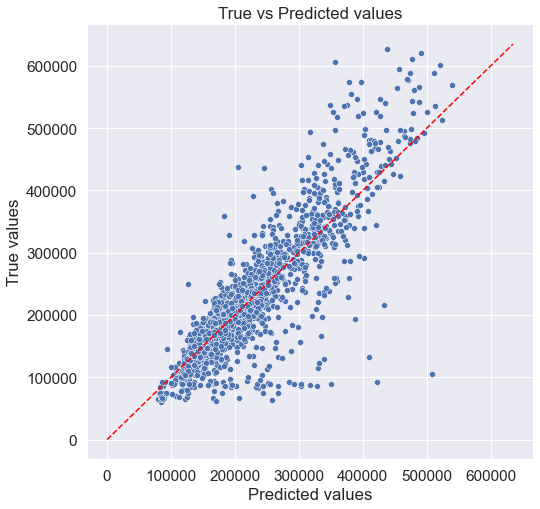

In [2319]:
reg1 = make_pipeline(RobustScaler(), KNeighborsRegressor(n_neighbors=25, leaf_size=15, p=1, metric='minkowski')) 
reg2 = RandomForestRegressor(max_depth=5, max_features=13, n_estimators=1000, random_state=1, n_jobs=-1)
reg3 = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5, max_features=None, 
                                                             min_samples_leaf=1, random_state=1),
                        max_features=13, n_estimators=200, random_state=1, n_jobs=-1)
reg4 = GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, random_state=1, 
                                 n_estimators=575, max_features='sqrt', loss='huber', learning_rate=0.017)
vote = VotingRegressor(estimators=[('knn', reg1), ('forest', reg2), ('bagging', reg3), ('boost', reg4)], 
                       weights=[1., 1.5, 2.0, 2.5])
vote.fit(X_train, y_train)
y_train_pred = vote.predict(X_train)
y_test_pred = vote.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
r2_dict.update({vote.__class__.__name__: [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]})

Подведем некоторые итоги:

In [2320]:
df_res = pd.DataFrame(r2_dict).transpose()
df_res.columns = ['Train', 'Test']
df_res.sort_values(by=['Test', 'Train'], ascending=False, inplace=True)

In [2321]:
df_res
# pipeline здесь имя класса для класса конвейера, который использовался в методе К ближних соседей

Train      Test
StackingRegressor          0.801035  0.773587
GradientBoostingRegressor  0.785024  0.772767
BaggingRegressor           0.774539  0.768832
VotingRegressor            0.771746  0.760642
RandomForestRegressor      0.747411  0.737359
CustomLinearRegression     0.710288  0.732955
DecisionTreeRegressor      0.718572  0.723536
Pipeline                   0.724172  0.722854
Lasso                      0.712669  0.722394
LinearRegression           0.712669  0.722394
RidgeCV                    0.712667  0.722391

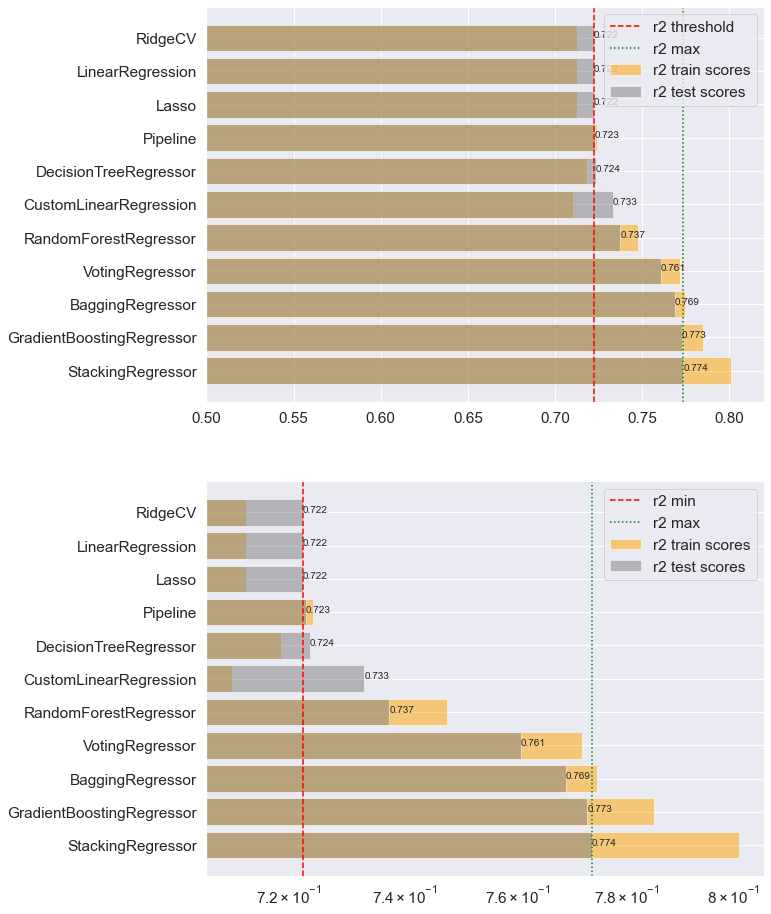

In [2322]:
plt.figure(figsize=(10, 16))
plt.subplot(2, 1, 1)
plt.barh(df_res.index, df_res['Train'], alpha=0.5, color='orange', label='r2 train scores')
plt.barh(df_res.index, df_res['Test'], alpha=0.5, color='gray', label='r2 test scores')
plt.axvline(df_res['Test'].min(), color='red', linestyle='--', label='r2 threshold')
plt.axvline(df_res['Test'].max(), color='green', linestyle=':', label='r2 max')
for index, value in enumerate(df_res['Test']):
    plt.text(value, index, f'{value:.3f}', fontsize=10)
plt.legend(loc='best')
plt.xlim([0.5, 0.82])
plt.subplot(2, 1, 2)
plt.barh(df_res.index, df_res['Train'], alpha=0.5, color='orange', label='r2 train scores')
plt.barh(df_res.index, df_res['Test'], alpha=0.5, color='gray', label='r2 test scores')
plt.axvline(df_res['Test'].min(), color='red', linestyle='--', label='r2 min')
plt.axvline(df_res['Test'].max(), color='green', linestyle=':', label='r2 max')
for index, value in enumerate(df_res['Test']):
    plt.text(value, index, f'{value:.3f}', fontsize=10)
plt.legend(loc='best')
plt.xscale('log')
plt.show()

Оптимальный регрессор с точки зрения метрики R2 (цель задания) является, неожиданно :), GradientBoostingRegressor (у StackingRegressor сильнее выражено переобучние), несмотря на небольшое переобучение. Необходимо повысить качество предобработки данных, попробовать тюнинг параметров VotingRegressor, StackingRegressor

In [2323]:
df_pred = pd.DataFrame()
df_pred['True'] = y_test[:20]
for regr in ((boost, bag, stack, vote)):
    df_pred[f'{regr.__class__.__name__}'] = regr.predict(X_test[:20, :])

In [2324]:
df_pred
# какие-то предсказания довольно точны, но, например 2, 5, 6, 7 совсем мимо

True  GradientBoostingRegressor  BaggingRegressor  \
0   183485.281250              175023.181583     176831.306721   
1   163180.484375              144759.986898     143469.469793   
2    83511.828125              221895.060300     220856.010811   
3   200879.625000              224959.409257     223453.298733   
4   132930.265625              142822.296888     142545.112336   
5   181252.531250              287610.090834     294040.561350   
6   627525.062500              473872.505686     470400.451388   
7    64298.214844              244931.397246     250491.874912   
8   210316.500000              186730.592817     186514.791424   
9   177118.484375              187282.638517     187242.478645   
10  100529.109375              110018.264787     111146.915687   
11  127196.765625              126978.025675     127456.327785   
12  296128.593750              306343.556974     295875.687990   
13  272178.750000              312722.395983     307040.446441   
14  273947.281250              270748.583037     266591.990652   
15  190173.890625              201436.651296     199035.824683   
16  184708.796875              173577.529551     171445.525283   
17  314422.375000              296856.504956     298001.220966   
18  166683.812500              161243.925238     163631.811271   
19  143280.515625              154305.615383     154812.922202   

    StackingRegressor  VotingRegressor  
0       179657.012529    174018.719058  
1       147912.376891    138765.554251  
2       224979.969521    235591.135693  
3       212359.866848    209448.400309  
4       142598.534662    144722.095606  
5       300716.396707    298010.468943  
6       456415.561487    437186.036169  
7       243375.090000    258646.109978  
8       188535.425714    182417.062636  
9       186658.051474    187619.039759  
10      107299.029842    119675.761372  
11      128214.842786    128190.832260  
12      295833.541952    279749.412989  
13      308314.343694    307777.615048  
14      263410.902024    257310.133795  
15      197539.016961    196935.533664  
16      172164.791446    172392.970133  
17      309185.282357    284879.272625  
18      169462.025630    163355.772497  
19      155233.936723    161492.590313

In [2325]:
df_pred['Custom'] = lr.predict(X_test_std[:20, :])

In [2326]:
df_pred

True  GradientBoostingRegressor  BaggingRegressor  \
0   183485.281250              175023.181583     176831.306721   
1   163180.484375              144759.986898     143469.469793   
2    83511.828125              221895.060300     220856.010811   
3   200879.625000              224959.409257     223453.298733   
4   132930.265625              142822.296888     142545.112336   
5   181252.531250              287610.090834     294040.561350   
6   627525.062500              473872.505686     470400.451388   
7    64298.214844              244931.397246     250491.874912   
8   210316.500000              186730.592817     186514.791424   
9   177118.484375              187282.638517     187242.478645   
10  100529.109375              110018.264787     111146.915687   
11  127196.765625              126978.025675     127456.327785   
12  296128.593750              306343.556974     295875.687990   
13  272178.750000              312722.395983     307040.446441   
14  273947.281250              270748.583037     266591.990652   
15  190173.890625              201436.651296     199035.824683   
16  184708.796875              173577.529551     171445.525283   
17  314422.375000              296856.504956     298001.220966   
18  166683.812500              161243.925238     163631.811271   
19  143280.515625              154305.615383     154812.922202   

    StackingRegressor  VotingRegressor         Custom  
0       179657.012529    174018.719058  188976.010214  
1       147912.376891    138765.554251  126876.051111  
2       224979.969521    235591.135693  212336.439612  
3       212359.866848    209448.400309  229076.546039  
4       142598.534662    144722.095606  136917.672855  
5       300716.396707    298010.468943  287177.288615  
6       456415.561487    437186.036169  510947.878376  
7       243375.090000    258646.109978  273077.363413  
8       188535.425714    182417.062636  194084.743314  
9       186658.051474    187619.039759  198450.400775  
10      107299.029842    119675.761372   97466.528123  
11      128214.842786    128190.832260  125740.245086  
12      295833.541952    279749.412989  292690.155459  
13      308314.343694    307777.615048  292414.807255  
14      263410.902024    257310.133795  265016.256333  
15      197539.016961    196935.533664  194206.546502  
16      172164.791446    172392.970133  187149.524672  
17      309185.282357    284879.272625  269602.181699  
18      169462.025630    163355.772497  174515.832429  
19      155233.936723    161492.590313  163121.577334

In [2327]:
# предсказать test_df и залить его на kaggle, блокнот на github

<h3>Факультативно</h3>

In [2328]:
from sklearn.cluster import KMeans

In [2329]:
train_df.head(1)

DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0          27    3.0  115.027313   93.524582           10.0      4   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  ...  Social_2  Social_3  \
0        10.0     2014.0   0.075424          1  ...      3097         0   

   Healthcare_1  Helthcare_2  Shops_1  Shops_2       Price  MedPriceDistrict  \
0        3300.0            0        0        1  305018.875     213530.788443   

   DistrictPrice  LifeStats  
0    2669.535159  -1.710101  

[1 rows x 22 columns]

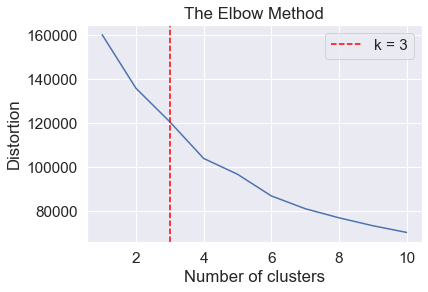

In [2408]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_selected_cbs.drop('Price', axis=1))
distortions = []
max_k = 10
for i in range(1, max_k + 1):
    if len(X) >= i:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0, tol=1e-04)
        kmeans.fit(X_std)
        distortions.append(kmeans.inertia_)

k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, 11), distortions)
ax.axvline(k, ls='--', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
plt.legend(loc='best')
plt.show()

In [2409]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
train_df['cluster'] = kmeans.fit_predict(X_std)

In [2410]:
columns = ['Cluster', 'Mean_value', 'Median_value', 'Count', 'Mode', 'MedPriceDistrict', 'Square']
result = pd.DataFrame(columns = columns)
for x in set(train_df['cluster']):
    cluster_df = train_df.loc[train_df['cluster'] == x]
    result.loc[x] = [x, cluster_df['Price'].mean(), cluster_df['Price'].median(), 
                     cluster_df['Price'].count(), cluster_df['Price'].mode()[0], 
                    cluster_df['MedPriceDistrict'].mean(), cluster_df['Square'].mean()]
result['Mean_value'] = result['Mean_value'].apply(lambda x: round(x, 2))
result['Count'] = result['Count'].astype(np.int16)
result

Cluster  Mean_value   Median_value  Count           Mode  MedPriceDistrict  \
0      0.0   161672.45  157612.328125   3052   59877.593750     162023.964802   
1      1.0   193065.38  186537.390625   4503  182938.078125     193611.865657   
2      2.0   318442.09  311528.093750   2445   64298.214844     306185.808457   

      Square  
0  58.513004  
1  44.476852  
2  74.836922

In [2411]:
labels = kmeans.predict(X_std)

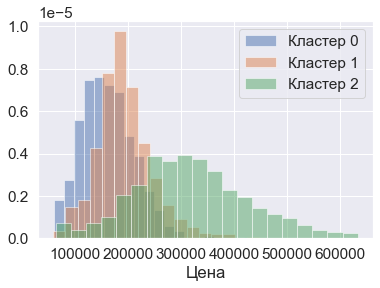

In [2412]:
plt.hist(y[labels == 0], bins=20, density=True, alpha=0.5)
plt.hist(y[labels == 1], bins=20, density=True, alpha=0.5)
plt.hist(y[labels == 2], bins=20, density=True, alpha=0.5)

plt.legend(['Кластер 0', 'Кластер 1', 'Кластер 2'])
plt.xlabel('Цена')

plt.show()

R2:	0.818
RMSE:	21315.333
MSE:	454343408.25
MSE_scaled:	2869.39


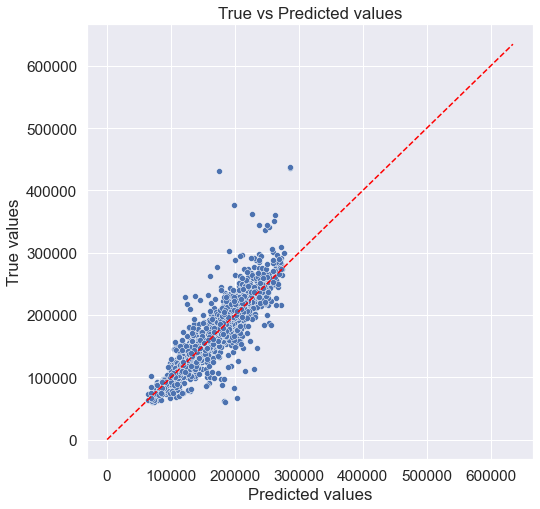

R2:	0.747
RMSE:	26145.496
MSE:	683586943.591
MSE_scaled:	4419.439


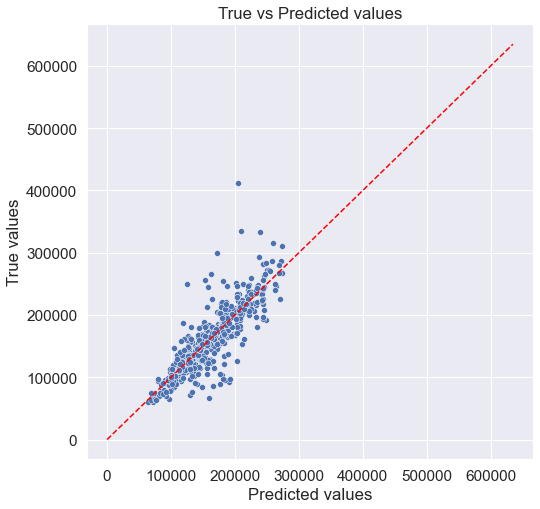

In [2413]:
X_train, X_test, y_train1, y_test1 = train_test_split(X[labels == 0], y[labels == 0], test_size=0.2, 
                                                    shuffle=True, random_state=1)
boost_cl = GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, 
                                  random_state=1, n_estimators=1000, 
                                  max_features='sqrt', loss='huber', learning_rate=0.017)
boost_cl.fit(X_train, y_train1)
y_train_pred1 = boost_cl.predict(X_train)
y_test_pred1 = boost_cl.predict(X_test)
evaluate_preds(y_train1, y_train_pred1)
evaluate_preds(y_test1, y_test_pred1)

R2:	0.649
RMSE:	32098.308
MSE:	1030301391.56
MSE_scaled:	5508.265


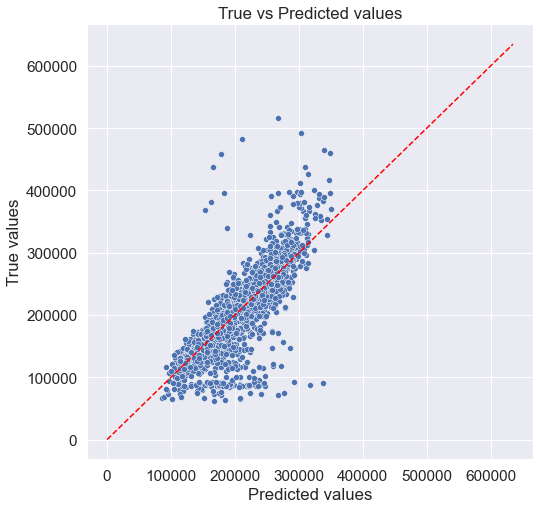

R2:	0.496
RMSE:	37254.308
MSE:	1387883447.266
MSE_scaled:	7503.876


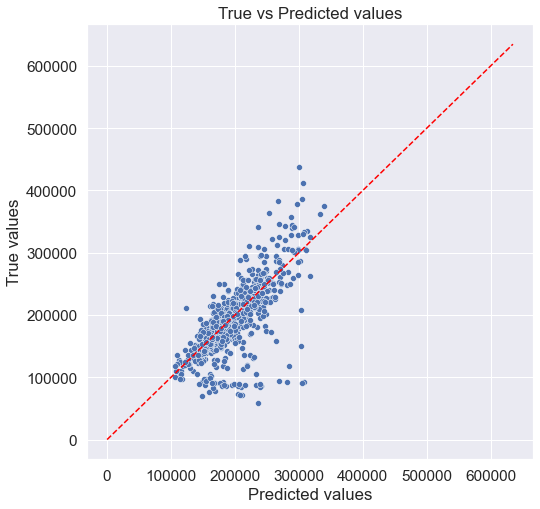

In [2414]:
X_train, X_test, y_train2, y_test2 = train_test_split(X[labels == 1], y[labels == 1], test_size=0.2, 
                                                    shuffle=True, random_state=1)
boost_cl2 = GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, 
                                  random_state=1, n_estimators=1000, 
                                  max_features='sqrt', loss='huber', learning_rate=0.017)
boost_cl2.fit(X_train, y_train2)
y_train_pred2 = boost_cl2.predict(X_train)
y_test_pred2 = boost_cl2.predict(X_test)
evaluate_preds(y_train2, y_train_pred2)
evaluate_preds(y_test2, y_test_pred2)

R2:	0.636
RMSE:	65707.049
MSE:	4317416297.404
MSE_scaled:	13901.742


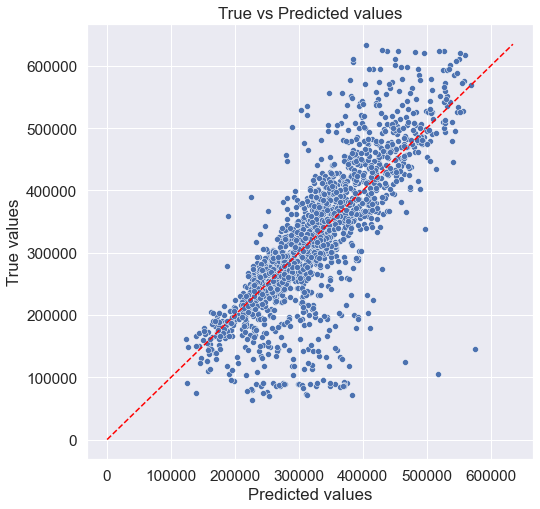

R2:	0.587
RMSE:	66371.639
MSE:	4405194450.217
MSE_scaled:	14051.77


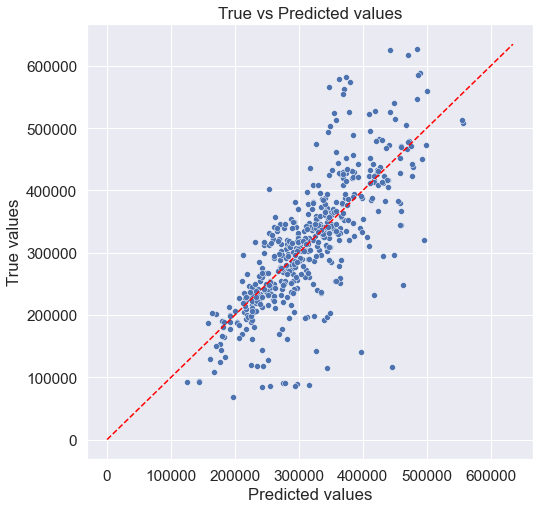

In [2415]:
X_train, X_test, y_train3, y_test3 = train_test_split(X[labels == 2], y[labels == 2], test_size=0.2, 
                                                    shuffle=True, random_state=1)
boost_cl3 = GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, 
                                  random_state=1, n_estimators=500, 
                                  max_features='sqrt', loss='huber', learning_rate=0.017)
boost_cl3.fit(X_train, y_train3)
y_train_pred3 = boost_cl3.predict(X_train)
y_test_pred3 = boost_cl3.predict(X_test)
evaluate_preds(y_train3, y_train_pred3)
evaluate_preds(y_test3, y_test_pred3)

In [2416]:
y_train_all = np.hstack([y_train1, y_train2, y_train3])
y_train_pred_all = np.hstack([y_train_pred1, y_train_pred2, y_train_pred3])

y_test_all = np.hstack([y_test1, y_test2, y_test3])
y_test_pred_all = np.hstack([y_test_pred1, y_test_pred2, y_test_pred3])

print('R2 при обучении: %.3f, при испытании: %.3f' % (r2_score(y_train_all, y_train_pred_all), 
                                                      r2_score(y_test_all, y_test_pred_all)))

R2 при обучении: 0.810, при испытании: 0.768


Значение R2 хуже, чем при обучении на полном наборе данных. Дальнейшие шаги: совершенствовать разбиение на кластеры, подбор регрессоров для каждого кластера и их гиперпараметров

In [2417]:
test_df.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0          44    1.0  36.847630   19.094183            5.0      5         9.0   
1          62    1.0  42.568134   42.493908           10.0      7        17.0   
2          27    2.0  59.463676   44.517311            9.0     19        19.0   
3          23    3.0  49.646030   33.893826            6.0      2         2.0   
4          74    1.0  53.837055   45.453350            3.0      8        17.0   

   HouseYear  Ecology_1  Ecology_2  ...  Social_1  Social_2  Social_3  \
0     1970.0   0.036122          1  ...        24      4378         0   
1     2017.0   0.072158          1  ...         2       629         1   
2     1977.0   0.211401          1  ...         9      1892         0   
3     1965.0   0.014073          1  ...         2       475         0   
4     1977.0   0.309479          1  ...        35      7715         4   

   Healthcare_1  Helthcare_2  Shops_1  Shops_2  MedPriceDistrict  \
0        3300.0            1        1        1     171145.169069   
1        3300.0            0        0        0     129107.218932   
2        3300.0            0        1        1     165683.084779   
3        3300.0            0        0        1     166687.735824   
4        3300.0            0        6        1     165071.825722   

   DistrictPrice  LifeStats  
0    4431.704675  -1.674011  
1    2859.977368  -1.523749  
2    2669.535159  -1.699476  
3    2109.194622  -1.711603  
4    3483.810063  -0.763394  

[5 rows x 21 columns]

In [2340]:
X_submission = test_df[['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Social_1', 
                 'Healthcare_1', 'MedPriceDistrict', 'DistrictPrice', 'LifeStats', 
                 'LifeSquare', 'Ecology_1']].values
final_pred = boost.predict(X_submission)

In [2341]:
final_pred.shape

(5000,)

<h3>Experimental</h3>

In [2418]:
X_all, y_all = train_df.drop(['Price', 'cluster'], axis=1).values, train_df['Price'].values

In [2419]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=1)

R2:	0.804
RMSE:	40679.896
MSE:	1654853965.963
MSE_scaled:	8617.296


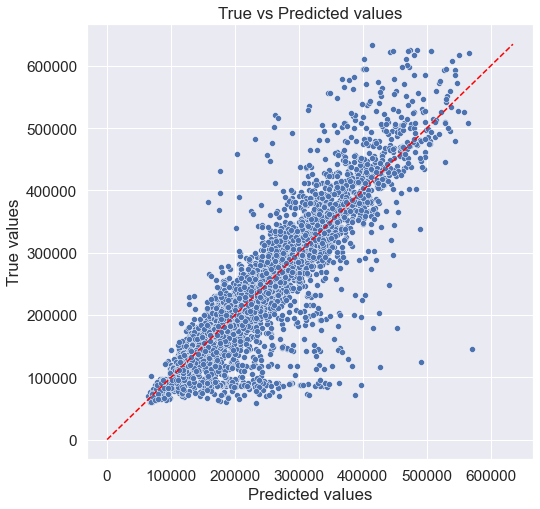

R2:	0.78
RMSE:	45176.09
MSE:	2040879095.161
MSE_scaled:	10588.617


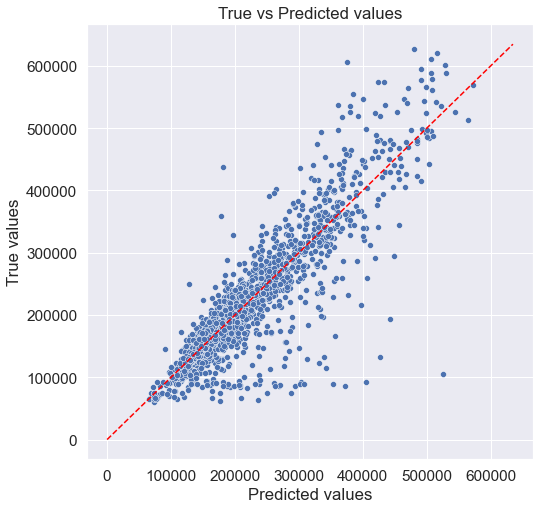

In [2420]:
boost_all = GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=55, 
                                  random_state=1, n_estimators=575, 
                                  max_features='sqrt', loss='huber', learning_rate=0.02)
boost_all.fit(X_train, y_train)
y_train_pred = boost_all.predict(X_train)
y_test_pred = boost_all.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)
# качественного скачка нет, значит и нет смысла использовать весь набор

In [2421]:
X_all, y_all = train_df.drop(['Price', 'cluster'], axis=1), train_df['Price']

In [2422]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=1)

In [2423]:
pca = PCA(n_components=16, random_state=1)
scaler = StandardScaler(with_mean=False)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

R2:	0.764
RMSE:	44663.347
MSE:	1994814557.097
MSE_scaled:	10387.568


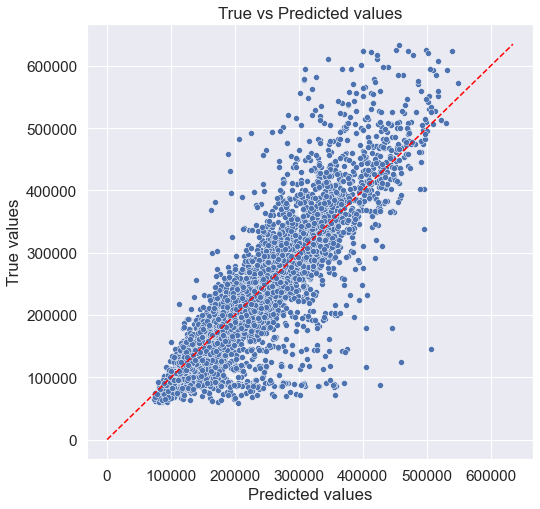

R2:	0.745
RMSE:	48615.0
MSE:	2363418191.228
MSE_scaled:	12262.034


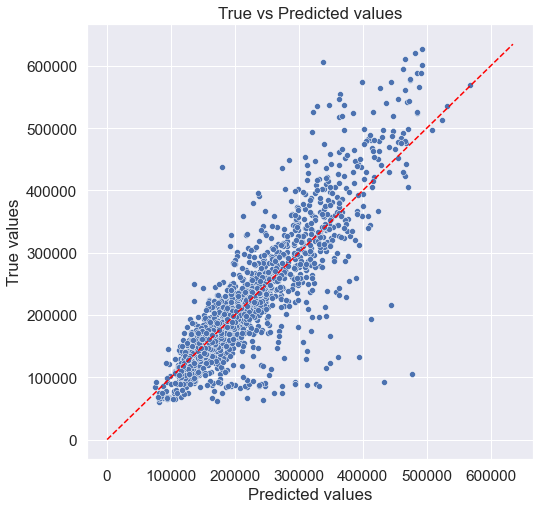

In [2424]:
boost_pca = GradientBoostingRegressor(criterion='mse', max_depth=4, min_samples_leaf=55, 
                                  random_state=1, n_estimators=625, 
                                  max_features='sqrt', loss='huber', learning_rate=0.017)
boost_pca.fit(X_train_pca, y_train)
y_train_pred = boost_pca.predict(X_train_pca)
y_test_pred = boost_pca.predict(X_test_pca)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)

Попробуем все-таки набор из класса ChooseBestSubset

In [2404]:
X, y = df_selected_cbs.drop('Price', axis=1), df_selected_cbs['Price']

In [2405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

R2:	0.804
RMSE:	40704.44
MSE:	1656851404.628
MSE_scaled:	8627.697


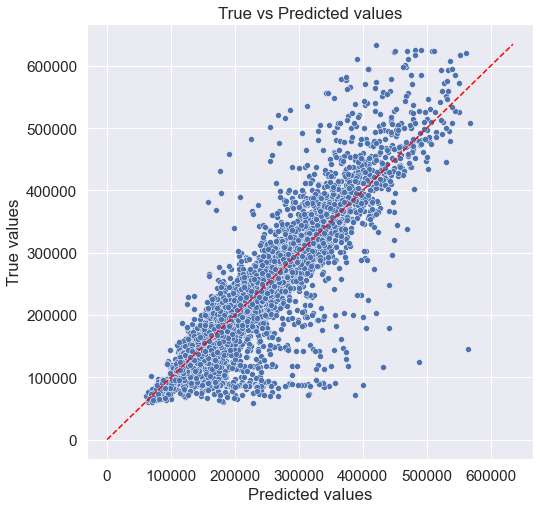

R2:	0.781
RMSE:	45071.926
MSE:	2031478515.949
MSE_scaled:	10539.844


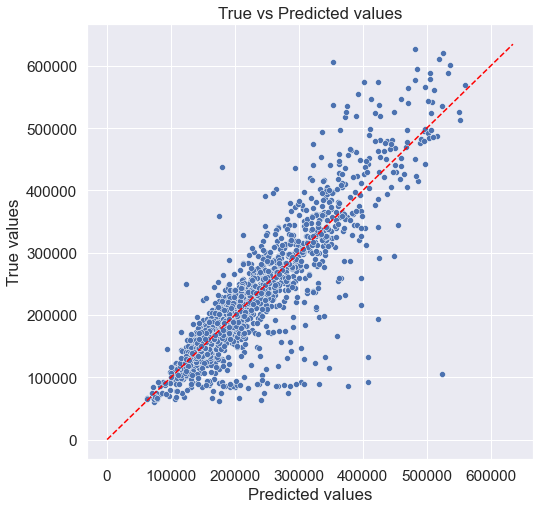

In [2395]:
boost_cbs = GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=55, 
                                  random_state=1, n_estimators=500, 
                                  max_features='sqrt', loss='huber', learning_rate=0.02)
boost_cbs.fit(X_train, y_train)
y_train_pred = boost_cbs.predict(X_train)
y_test_pred = boost_cbs.predict(X_test)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_test, y_test_pred)

возможно, что лучше всего использовать отбор признаков

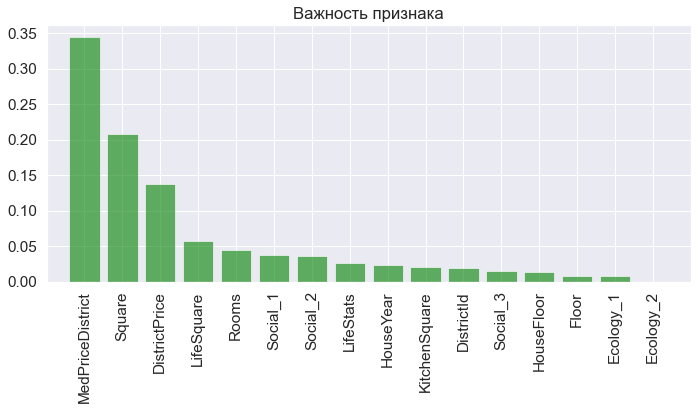

In [2407]:
feat_labels = np.array(df_selected_cbs.drop('Price', axis=1).columns)
importances = boost_cbs.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Важность признака')
plt.bar(range(X.shape[1]), importances[indices], align='center', alpha=0.6, color='green')
plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()